In [ ]:
import os
import cv2
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import gc
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation, PillowWriter
import math
import csv
from collections import Counter

# Q1

Q1 PART 1: Utilities Ready
VIDEO_PATH: /content/q1.2.mp4
OUTPUT_DIR: /content/cv25_outputs
Q1 PART 2: Loading Video and Setting Up ROI
Video FPS: 60.00
Total frames: 2613
Original resolution: 3840x2160
Resize factor: 0.75
Process every 2 frames
Loading frames in batches...
  Batch: frames 0 to 29
  Batch: frames 30 to 59
  Batch: frames 60 to 89
  Batch: frames 90 to 119
  Batch: frames 120 to 149

Loaded 150 frames successfully
Frame shape: (1620, 2880, 3)
Original ROI: (1250, 1050, 1700, 1050)
Adjusted ROI: (937, 787, 1275, 787)
Grid points inside ROI: 2496
Grid spacing: 20 pixels
Saved ROI sample: /content/cv25_outputs/q1_roi_sample.png
Q1 PART 3: Computing Sparse Optical Flow (Lucas-Kanade)
Window size: 9x9
Eigenvalue threshold: 0.5 (for reliability)
Computing flows...

  Frame pair 0/149 - Reliable points: 2342/2496
  Frame pair 20/149 - Reliable points: 2355/2496
  Frame pair 40/149 - Reliable points: 2335/2496
  Frame pair 60/149 - Reliable points: 2181/2496
  Frame pair 80/149 

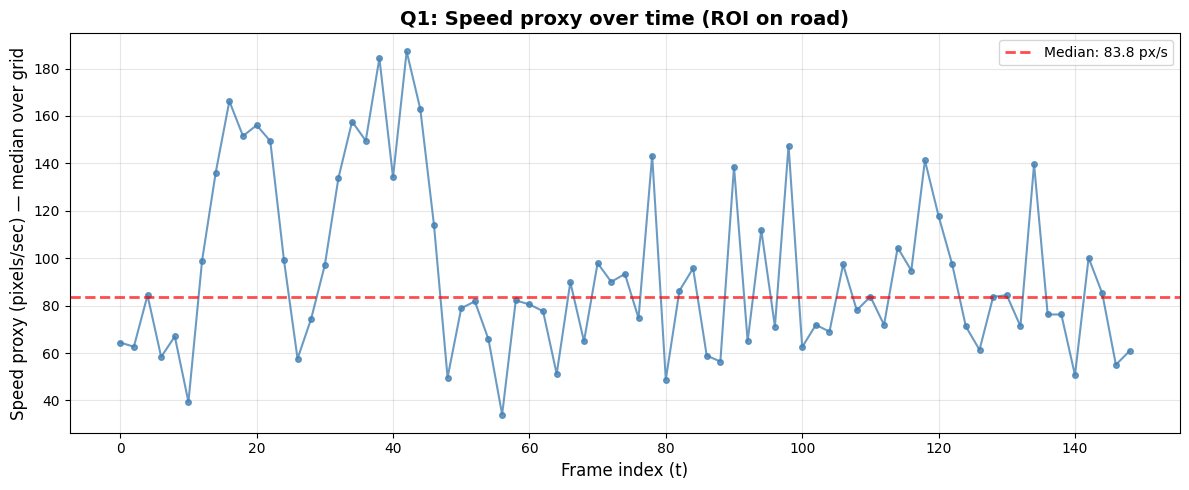

 Saved: /content/cv25_outputs/q1_speed_proxy.png
Total frames processed: 150
Frame pairs analyzed: 75
Grid points tracked: 2496
Speed Statistics:
  Mean speed:    93.73 px/s
  Median speed:  83.78 px/s
  Max speed:    187.20 px/s
  Min speed:     34.04 px/s
  Std dev:       36.14 px/s
Outputs Generated:
  /content/cv25_outputs/q1_roi_sample.png
  /content/cv25_outputs/q1_flow_overlay_low.png
  /content/cv25_outputs/q1_flow_overlay_mid.png
  /content/cv25_outputs/q1_flow_overlay_high.png
  /content/cv25_outputs/q1_speed_proxy.png
Observations:
  Speed variation range: 153.17 px/s
   High speed variation detected - significant traffic activity
   Suggests varying vehicle speeds or stop-and-go traffic
  Average reliable tracking points: 2271.4/2496 (91.0%)


In [ ]:
"""
Q1: Vehicle Motion - Velocity Proxy via Sparse Optical Flow
Complete implementation with all 4 parts

FROM-SCRATCH IMPLEMENTATION:
- Image gradients: Central differences (Ix, Iy)
- Temporal gradient: It = I2 - I1
- Lucas-Kanade least-squares solver: (A^T A)v = -A^T It per window
- Eigenvalue-based reliability check on A^T A
- NO library optical flow functions used (cv2 only for I/O)
"""
# Q1 PART 1: IMPORTS + GPU UTILITIES + GRADIENT AND PYRAMID HELPERS


# Paths (Colab)
VIDEO_PATH = "/content/q1.2.mp4"
OUTPUT_DIR = "/content/cv25_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# GPU helpers
def to_gpu(x):
    """Transfer numpy array to GPU (CuPy)"""
    return cp.asarray(x)

def to_cpu(x):
    """Transfer CuPy array back to CPU (numpy)"""
    return cp.asnumpy(x)

# Simple 1D Gaussian kernel generator on GPU
def gauss1d_cp(radius=2, sigma=1.0):
    """
    Generate 1D Gaussian kernel on GPU
    Args:
        radius: kernel half-width
        sigma: standard deviation
    Returns:
        CuPy array: normalized Gaussian kernel
    """
    r = radius
    xs = cp.arange(-r, r+1, dtype=cp.float32)
    g = cp.exp(-(xs**2)/(2*(sigma**2)))
    g = g / g.sum()
    return g

# Separable Gaussian blur (GPU)
def gaussian_blur_cp(img_cp, radius=2, sigma=1.0):
    """
    Apply separable Gaussian blur on GPU
    Args:
        img_cp: 2D CuPy float32 array
        radius: blur radius
        sigma: Gaussian standard deviation
    Returns:
        Blurred image (CuPy array)
    """
    g = gauss1d_cp(radius, sigma)
    pad = radius
    img_p = cp.pad(img_cp, ((pad,pad),(pad,pad)), mode='edge')

    # Convolve rows
    tmp = cp.empty_like(img_p)
    for r in range(img_p.shape[0]):
        tmp[r,:] = cp.convolve(img_p[r,:], g, mode='same')

    # Convolve columns
    out = cp.empty_like(tmp)
    for c in range(tmp.shape[1]):
        out[:,c] = cp.convolve(tmp[:,c], g, mode='same')

    # Crop to original size
    return out[pad:pad+img_cp.shape[0], pad:pad+img_cp.shape[1]]

# Build Gaussian pyramid (list of CuPy arrays)
def build_pyramid_np(img_np, levels=3):
    """
    Build Gaussian pyramid from scratch
    Args:
        img_np: numpy grayscale float32 image
        levels: number of pyramid levels
    Returns:
        List of CuPy arrays (coarse to fine)
    """
    pyr = [to_gpu(img_np.astype(np.float32))]
    for i in range(1, levels):
        prev = pyr[-1]
        blurred = gaussian_blur_cp(prev, radius=2, sigma=1.0)
        # Downsample by 2
        down = blurred[::2, ::2]
        pyr.append(down)
    return pyr

# Image gradients (central differences) on GPU - FROM SCRATCH
def image_gradients_cp(img_cp):
    """
    Compute spatial gradients using central differences
    Args:
        img_cp: 2D CuPy float32 array
    Returns:
        Ix, Iy: horizontal and vertical gradients (CuPy arrays)
    """
    # Pad to compute central differences at borders
    p = cp.pad(img_cp, ((1,1),(1,1)), mode='edge')

    # Central differences: I'(x) = 0.5 * (I(x+1) - I(x-1))
    Ix = 0.5 * (p[1:-1, 2:] - p[1:-1, :-2])
    Iy = 0.5 * (p[2:, 1:-1] - p[:-2, 1:-1])

    return Ix, Iy

# Warping helper (uses OpenCV remap for efficiency, but LK doesn't use this)
def warp_image_numpy(img_np, flow_u, flow_v):
    """
    Warp image using flow field
    Args:
        img_np: HxW or HxWx3 numpy uint8 image
        flow_u, flow_v: HxW numpy float displacement fields
    Returns:
        Warped image (numpy array)
    """
    h, w = flow_u.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (xx + flow_u).astype(np.float32)
    map_y = (yy + flow_v).astype(np.float32)
    warped = cv2.remap(img_np, map_x, map_y,
                       interpolation=cv2.INTER_LINEAR,
                       borderMode=cv2.BORDER_REPLICATE)
    return warped


print("Q1 PART 1: Utilities Ready")

print(f"VIDEO_PATH: {VIDEO_PATH}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

# Q1 PART 2: READ FRAMES, CHOOSE ROI, CREATE GRID POINTS
# PARAMETERS
# CORRECTED ROI - positioned on illuminated road in center of frame
ROI = (1250, 1050, 1700, 1050)   # (x, y, w, h) - adjust if needed
GRID_SPACING = 20            # pixels between grid sample points
LK_WIN = 9                   # LK window size (must be odd)
PYR_LEVELS = 3               # pyramid levels (for future use)
PROCESS_EVERY_N = 2          # Process every Nth frame to save computation
RESIZE_FACTOR = 0.75         # Resize to 75% to save RAM


print("Q1 PART 2: Loading Video and Setting Up ROI")
# Read video metadata
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video FPS: {fps:.2f}")
print(f"Total frames: {frame_count}")
print(f"Original resolution: {orig_width}x{orig_height}")
print(f"Resize factor: {RESIZE_FACTOR}")
print(f"Process every {PROCESS_EVERY_N} frames")

# Limit frames for RAM efficiency
max_frames = min(frame_count, 150)

# Read and process frames in batches
frames = []
gray = []
batch_size = 30

print("Loading frames in batches...")
for batch_start in range(0, max_frames, batch_size):
    batch_end = min(batch_start + batch_size, max_frames)
    print(f"  Batch: frames {batch_start} to {batch_end-1}")

    for i in range(batch_start, batch_end):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, fr = cap.read()
        if not ret:
            break

        # Resize to save RAM
        if RESIZE_FACTOR != 1.0:
            new_w = int(fr.shape[1] * RESIZE_FACTOR)
            new_h = int(fr.shape[0] * RESIZE_FACTOR)
            fr = cv2.resize(fr, (new_w, new_h))

        frames.append(fr)

        # Convert to grayscale immediately
        g = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY).astype(np.float32)
        gray.append(g)

    gc.collect()  # Force garbage collection

cap.release()

if len(frames) < 2:
    raise RuntimeError("Need at least 2 frames in the video for optical flow.")

print(f"\nLoaded {len(frames)} frames successfully")
print(f"Frame shape: {frames[0].shape}")

# Adjust ROI for resize factor
roi_adjusted = tuple(int(x * RESIZE_FACTOR) for x in ROI)
x_roi, y_roi, w_roi, h_roi = roi_adjusted

print(f"Original ROI: {ROI}")
print(f"Adjusted ROI: {roi_adjusted}")

# Grid points inside ROI
def grid_points_in_roi(roi, spacing=20):
    """
    Generate uniform grid of points inside ROI
    Args:
        roi: (x, y, w, h) tuple
        spacing: pixel spacing between points
    Returns:
        Nx2 numpy array of (x, y) coordinates
    """
    x, y, w, h = roi
    xs = np.arange(x + spacing//2, x + w, spacing)
    ys = np.arange(y + spacing//2, y + h, spacing)
    pts = np.array([[xx, yy] for yy in ys for xx in xs], dtype=np.float32)
    return pts

pts = grid_points_in_roi(roi_adjusted, spacing=GRID_SPACING)
print(f"Grid points inside ROI: {pts.shape[0]}")
print(f"Grid spacing: {GRID_SPACING} pixels")

# Save a sample frame with ROI for inspection
sample_frame_idx = len(frames) // 2
sample = frames[sample_frame_idx].copy()

# Draw ROI rectangle
cv2.rectangle(sample, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi),
              (0, 255, 0), 2)

# Draw grid points
for px, py in pts:
    cv2.circle(sample, (int(px), int(py)), 2, (0, 255, 255), -1)

# Add text annotation
cv2.putText(sample, f"ROI: {pts.shape[0]} tracking points",
            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
cv2.putText(sample, f"Frame {sample_frame_idx}/{len(frames)}",
            (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

roi_sample_path = os.path.join(OUTPUT_DIR, "q1_roi_sample.png")
cv2.imwrite(roi_sample_path, sample)
print(f"Saved ROI sample: {roi_sample_path}")

# Q1 PART 3: IMPLEMENT WINDOWED LUCAS-KANADE AND COMPUTE SPARSE FLOWS

print("Q1 PART 3: Computing Sparse Optical Flow (Lucas-Kanade)")

def lk_windowed_gpu(img1_np, img2_np, points, win=9):
    """
    Windowed Lucas-Kanade optical flow - FROM SCRATCH

    For each point, solves the least-squares problem:
        (A^T A) v = -A^T It
    where A = [Ix, Iy] over the window, It = I2 - I1

    Args:
        img1_np, img2_np: numpy float32 grayscale images (H, W)
        points: Nx2 numpy array of (x,y) coordinates
        win: odd window size
    Returns:
        Nx2 numpy array of flows (u, v) in pixels
    """
    half = win // 2

    # Move images to GPU
    I1 = to_gpu(img1_np)
    I2 = to_gpu(img2_np)

    # Compute spatial gradients on GPU (from scratch using central differences)
    Ix, Iy = image_gradients_cp(I1)

    # Compute temporal gradient (frame difference)
    It = I2 - I1

    H, W = img1_np.shape
    flows = np.zeros((len(points), 2), dtype=np.float32)

    # Process each grid point
    for idx, (x, y) in enumerate(points):
        xi = int(round(x))
        yi = int(round(y))
        x0, x1 = xi - half, xi + half + 1
        y0, y1 = yi - half, yi + half + 1

        # Skip windows that go out of bounds
        if x0 < 0 or y0 < 0 or x1 > W or y1 > H:
            continue

        # Extract window patches and flatten
        Ixw = Ix[y0:y1, x0:x1].ravel()
        Iyw = Iy[y0:y1, x0:x1].ravel()
        Itw = It[y0:y1, x0:x1].ravel()

        # Build A matrix: each row is [Ix, Iy] at a pixel
        A = cp.stack([Ixw, Iyw], axis=1)  # Shape: (win*win, 2)

        # Compute A^T A (2x2 matrix)
        ATA = A.T @ A

        # Check eigenvalues for reliability
        # Small eigenvalues indicate aperture problem or low texture
        eigvals = cp.linalg.eigvalsh(ATA)
        min_eigval = float(eigvals[0])

        # Threshold for reliable window (adjust as needed)
        if min_eigval < 0.5:
            continue  # Skip unreliable windows

        # Compute A^T b where b = It
        ATb = A.T @ Itw  # Shape: (2,)

        # Regularize for numerical stability (smaller since we check eigenvalues)
        ATA += cp.eye(2, dtype=cp.float32) * 1e-7

        # Solve: (A^T A) v = -A^T It
        try:
            v = - cp.linalg.solve(ATA, ATb)
            flows[idx] = to_cpu(v)
        except:
            # If solve fails, leave as zero
            pass

    # Clear GPU memory
    del I1, I2, Ix, Iy, It
    cp.get_default_memory_pool().free_all_blocks()

    return flows

# Compute sparse flows for consecutive frame pairs
all_sparse_flows = []
processed_frame_pairs = []

print(f"Window size: {LK_WIN}x{LK_WIN}")
print(f"Eigenvalue threshold: 0.5 (for reliability)")
print(f"Computing flows...\n")

for t in range(0, len(gray) - 1, PROCESS_EVERY_N):
    if t + 1 >= len(gray):
        break

    # Enhance contrast for better gradient quality
    I1 = cv2.equalizeHist(cv2.convertScaleAbs(gray[t]))
    I2 = cv2.equalizeHist(cv2.convertScaleAbs(gray[t + 1]))

    # Compute Lucas-Kanade flow
    flows = lk_windowed_gpu(I1, I2, pts, win=LK_WIN)
    all_sparse_flows.append(flows)
    processed_frame_pairs.append(t)

    # Progress indicator
    if (t // PROCESS_EVERY_N) % 10 == 0:
        reliable_count = np.count_nonzero(np.any(flows != 0, axis=1))
        print(f"  Frame pair {t}/{len(gray)-1} - Reliable points: {reliable_count}/{len(pts)}")

    gc.collect()

print(f"\n Computed sparse flows for {len(all_sparse_flows)} frame pairs")
print()


# Q1 PART 4: OVERLAY VECTORS, COMPUTE SPEED PROXY, AND PLOT

# Compute speed proxy per frame pair
fps_val = fps or 30.0
speed_proxy = []

print("Computing speed proxy (median flow magnitude × FPS)...")
for flows in all_sparse_flows:
    # Compute magnitude of each flow vector
    mags = np.linalg.norm(flows, axis=1)

    # Use median for robustness to outliers
    median_pix_per_frame = float(np.median(mags))

    # Convert to pixels/sec accounting for frame skip and resize
    pix_per_sec = median_pix_per_frame * fps_val * PROCESS_EVERY_N / RESIZE_FACTOR
    speed_proxy.append(pix_per_sec)

print(f" Computed speed proxy for {len(speed_proxy)} frame pairs")
print()

# Save overlay images for low, medium, high activity frames
if len(all_sparse_flows) == 0:
    raise RuntimeError("No flows computed; check video and ROI")

# Find frames with low, medium, high speeds
speed_sorted_idx = np.argsort(speed_proxy)
idx_low = speed_sorted_idx[len(speed_sorted_idx) // 4]
idx_mid = speed_sorted_idx[len(speed_sorted_idx) // 2]
idx_high = speed_sorted_idx[-len(speed_sorted_idx) // 4]

print("Generating flow overlay visualizations...")
print(f"  Low activity frame: {processed_frame_pairs[idx_low]} (speed: {speed_proxy[idx_low]:.1f} px/s)")
print(f"  Mid activity frame: {processed_frame_pairs[idx_mid]} (speed: {speed_proxy[idx_mid]:.1f} px/s)")
print(f"  High activity frame: {processed_frame_pairs[idx_high]} (speed: {speed_proxy[idx_high]:.1f} px/s)")
print()

for label, idx in [("low", idx_low), ("mid", idx_mid), ("high", idx_high)]:
    frame_idx = processed_frame_pairs[idx]
    img = frames[frame_idx].copy()
    flows = all_sparse_flows[idx]

    # Draw ROI rectangle
    cv2.rectangle(img, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi),
                  (0, 255, 0), 2)

    # Draw flow vectors with scaling for visibility
    scale = 3.0
    for (px, py), (u, v) in zip(pts, flows):
        if u == 0 and v == 0:
            continue  # Skip zero flows (unreliable points)

        x_i, y_i = int(px), int(py)
        end = (int(round(x_i + u * scale)), int(round(y_i + v * scale)))
        mag = np.sqrt(u**2 + v**2)

        # Color code by magnitude: blue (slow) -> green (fast)
        color = (int(min(255, 255 - mag * 10)),
                 int(min(255, mag * 10)),
                 0)
        cv2.arrowedLine(img, (x_i, y_i), end, color, 2, tipLength=0.3)

    # Add annotation
    speed_text = f"Speed: {speed_proxy[idx]:.1f} px/s ({label} activity)"
    cv2.putText(img, speed_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0, 255, 0), 2)
    cv2.putText(img, f"Frame {frame_idx}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Save overlay
    outp = os.path.join(OUTPUT_DIR, f"q1_flow_overlay_{label}.png")
    cv2.imwrite(outp, img)
    print(f"   Saved: {outp}")

# Plot speed proxy over time
print("Generating speed proxy time series plot...")
plt.figure(figsize=(12, 5))
plt.plot(processed_frame_pairs, speed_proxy, marker='o', markersize=4,
         linewidth=1.5, color='steelblue', alpha=0.8)
plt.axhline(y=np.median(speed_proxy), color='red', linestyle='--',
            linewidth=2, alpha=0.7, label=f'Median: {np.median(speed_proxy):.1f} px/s')
plt.xlabel("Frame index (t)", fontsize=12)
plt.ylabel("Speed proxy (pixels/sec) — median over grid", fontsize=12)
plt.title("Q1: Speed proxy over time (ROI on road)", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, "q1_speed_proxy.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f" Saved: {plot_path}")

print(f"Total frames processed: {len(frames)}")
print(f"Frame pairs analyzed: {len(all_sparse_flows)}")
print(f"Grid points tracked: {pts.shape[0]}")

print("Speed Statistics:")
print(f"  Mean speed:   {np.mean(speed_proxy):6.2f} px/s")
print(f"  Median speed: {np.median(speed_proxy):6.2f} px/s")
print(f"  Max speed:    {np.max(speed_proxy):6.2f} px/s")
print(f"  Min speed:    {np.min(speed_proxy):6.2f} px/s")
print(f"  Std dev:      {np.std(speed_proxy):6.2f} px/s")

print("Outputs Generated:")
print(f"  {os.path.join(OUTPUT_DIR, 'q1_roi_sample.png')}")
print(f"  {os.path.join(OUTPUT_DIR, 'q1_flow_overlay_low.png')}")
print(f"  {os.path.join(OUTPUT_DIR, 'q1_flow_overlay_mid.png')}")
print(f"  {os.path.join(OUTPUT_DIR, 'q1_flow_overlay_high.png')}")
print(f"  {os.path.join(OUTPUT_DIR, 'q1_speed_proxy.png')}")

print("Observations:")
speed_range = np.max(speed_proxy) - np.min(speed_proxy)
print(f"  Speed variation range: {speed_range:.2f} px/s")
if np.std(speed_proxy) > 20:
    print("   High speed variation detected - significant traffic activity")
    print("   Suggests varying vehicle speeds or stop-and-go traffic")
elif np.std(speed_proxy) > 5:
    print("   Moderate speed variation - steady traffic flow")
    print("   Suggests consistent vehicle movement patterns")
else:
    print("   Low speed variation - minimal or constant traffic")
    print("   Suggests either low traffic or constant-speed flow")

# Count reliable points per frame
reliable_counts = [np.count_nonzero(np.any(f != 0, axis=1)) for f in all_sparse_flows]
avg_reliable = np.mean(reliable_counts)
print(f"  Average reliable tracking points: {avg_reliable:.1f}/{pts.shape[0]} ({avg_reliable/pts.shape[0]*100:.1f}%)")


# Q2

In [ ]:
"""
Q2: Video Retiming - One Intermediate Frame for Slow Motion
Complete implementation with all 4 parts

Generates 2× slow-motion video by synthesizing intermediate frames using:
- Forward and backward Lucas-Kanade optical flow
- Halfway warping and blending

DEPENDS ON Q1: Requires frames, gray, fps, and functions from Q1 to be loaded
"""

# Verify Q1 data is available
if 'frames' not in globals() or 'gray' not in globals():
    raise RuntimeError("Q1 must be run first! Need frames, gray, and helper functions.")

print(f" Using {len(frames)} frames from Q1")
print(f" Frame resolution: {frames[0].shape[:2]}")

# Q2 PART 1: PARAMETERS FOR RETIMING SEGMENT AND DENSE GRID SAMPLING

# Parameters
START_FRAME = 0                                    # Start from first frame
NUM_PAIRS = min(20, len(gray) - 1)                # Process up to 20 pairs
DENSE_SUBSAMPLE = 4                               # Grid every 4 pixels (dense-ish)
LK_WIN = 9                                        # LK window size (same as Q1)

h, w = gray[0].shape

print(f"Start frame: {START_FRAME}")
print(f"Number of pairs to process: {NUM_PAIRS}")
print(f"Dense grid subsampling: every {DENSE_SUBSAMPLE} pixels")
print(f"LK window size: {LK_WIN}×{LK_WIN}")
print(f"Frame dimensions: {w}×{h}")


# Build dense sampling grid points
px = np.arange(0, w, DENSE_SUBSAMPLE)
py = np.arange(0, h, DENSE_SUBSAMPLE)
grid_pts = np.array([[x, y] for y in py for x in px], dtype=np.float32)

print(f"Dense grid points: {grid_pts.shape[0]} points")
print(f"Grid coverage: {len(px)}×{len(py)} = {len(px) * len(py)} points")

# Q2 PART 2: COMPUTE FORWARD AND BACKWARD FLOWS, INTERPOLATE TO DENSE

def sparse_to_dense(u_sparse, v_sparse, sample_pts, H, W):
    """
    Interpolate sparse u,v onto full HxW grid using scipy.griddata (linear).

    Args:
        u_sparse, v_sparse: length N arrays of sparse flow components
        sample_pts: Nx2 numpy array of (x,y) coordinates
        H, W: target height and width
    Returns:
        u_dense, v_dense: HxW numpy arrays of interpolated flow
    """
    # Create full image grid
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    XY = np.vstack((X.ravel(), Y.ravel())).T

    # Interpolate sparse flow to dense grid (linear interpolation)
    u_dense = griddata(sample_pts, u_sparse, XY, method='linear', fill_value=0.0).reshape(H, W)
    v_dense = griddata(sample_pts, v_sparse, XY, method='linear', fill_value=0.0).reshape(H, W)

    return u_dense, v_dense

# Storage for dense flow fields
synth_mid_frames = []  # List of (u_fwd, v_fwd, u_bwd, v_bwd) tuples
example_pair_idx = START_FRAME  # Save this pair for visualization

print(f"Computing bidirectional flow for {NUM_PAIRS} frame pairs...")
print()

for t in range(START_FRAME, START_FRAME + NUM_PAIRS):
    I0 = gray[t]
    I1 = gray[t + 1]

    # Enhance contrast for better flow quality
    I0_eq = cv2.equalizeHist(cv2.convertScaleAbs(I0))
    I1_eq = cv2.equalizeHist(cv2.convertScaleAbs(I1))

    # Forward sparse flow: I0 -> I1
    print(f"  Pair {t}: Computing forward flow (I{t} → I{t+1})...")
    fwd_sparse = lk_windowed_gpu(I0_eq, I1_eq, grid_pts, win=LK_WIN)

    # Backward sparse flow: I1 -> I0
    print(f"  Pair {t}: Computing backward flow (I{t+1} → I{t})...")
    bwd_sparse = lk_windowed_gpu(I1_eq, I0_eq, grid_pts, win=LK_WIN)

    # Interpolate to dense fields
    print(f"  Pair {t}: Interpolating to dense flow fields...")
    u_fwd, v_fwd = sparse_to_dense(fwd_sparse[:, 0], fwd_sparse[:, 1], grid_pts, h, w)
    u_bwd, v_bwd = sparse_to_dense(bwd_sparse[:, 0], bwd_sparse[:, 1], grid_pts, h, w)

    synth_mid_frames.append((u_fwd, v_fwd, u_bwd, v_bwd))

    # Print statistics
    fwd_mag = np.sqrt(u_fwd**2 + v_fwd**2)
    bwd_mag = np.sqrt(u_bwd**2 + v_bwd**2)
    print(f"  Pair {t}: Forward flow mean: {np.mean(fwd_mag):.2f} px, "
          f"Backward flow mean: {np.mean(bwd_mag):.2f} px")
    print()

    gc.collect()

print(f"Computed dense bidirectional flows for {len(synth_mid_frames)} pairs")
print()


# Q2 PART 3: HALFWAY WARPS AND BLENDING
synth_images = []  # Synthesized middle frames
original_pairs = []  # Store (I0, I1) pairs for comparison

print("Warping strategy:")
print(" Warp I_t forward by 0.5 × forward_flow")
print(" Warp I_{t+1} backward by 0.5 × backward_flow")
print(" Blend with simple average")
print()

for idx, (u_fwd, v_fwd, u_bwd, v_bwd) in enumerate(synth_mid_frames, start=START_FRAME):
    print(f"  Synthesizing middle frame for pair {idx}...")

    # Get color frames for warping (numpy BGR)
    I0_color = frames[idx]
    I1_color = frames[idx + 1]

    # Store original pair for comparison
    if len(original_pairs) < 5:  # Save first few for visualization
        original_pairs.append((I0_color.copy(), I1_color.copy()))

    # Compute half flows for halfway warps
    u_fwd_half = 0.5 * u_fwd
    v_fwd_half = 0.5 * v_fwd
    u_bwd_half = 0.5 * u_bwd
    v_bwd_half = 0.5 * v_bwd

    # Warp I0 forward halfway and I1 backward halfway
    mid0 = warp_image_numpy(I0_color, u_fwd_half, v_fwd_half)
    mid1 = warp_image_numpy(I1_color, u_bwd_half, v_bwd_half)

    # Blend the two halfway warps (simple average)
    mid = ((mid0.astype(np.float32) + mid1.astype(np.float32)) / 2.0).astype(np.uint8)

    synth_images.append(mid)

    if idx == START_FRAME:
        print(f"     Warped I{idx} forward: {np.mean(np.abs(u_fwd_half)):.2f} px displacement")
        print(f"     Warped I{idx+1} backward: {np.mean(np.abs(u_bwd_half)):.2f} px displacement")

print(f" Synthesized {len(synth_images)} intermediate frames")

# VISUALIZATION: SAVE EXAMPLE FRAMES AND DIFFERENCE HEATMAPS

# Save example original frames and synthesized middle frame
if len(synth_images) > 0 and len(original_pairs) > 0:
    example_idx = 0
    I0_example = original_pairs[example_idx][0]
    I1_example = original_pairs[example_idx][1]
    mid_example = synth_images[example_idx]

    # Save original frames
    cv2.imwrite(os.path.join(OUTPUT_DIR, "q2_original_I0.png"), I0_example)
    cv2.imwrite(os.path.join(OUTPUT_DIR, "q2_original_I1.png"), I1_example)
    cv2.imwrite(os.path.join(OUTPUT_DIR, "q2_synthesized_middle.png"), mid_example)

    print(f"Saved: q2_original_I0.png (frame {START_FRAME})")
    print(f"Saved: q2_original_I1.png (frame {START_FRAME + 1})")
    print(f"Saved: q2_synthesized_middle.png")


    # Compute difference heatmaps
    print("Computing difference heatmaps...")

    # Before: difference between consecutive original frames
    diff_before = cv2.absdiff(I0_example, I1_example)

    # After: difference between synthesized middle and average of originals
    avg_original = ((I0_example.astype(np.float32) + I1_example.astype(np.float32)) / 2.0).astype(np.uint8)
    diff_after = cv2.absdiff(mid_example, avg_original)

    # Create colored heatmaps for better visualization
    diff_before_gray = cv2.cvtColor(diff_before, cv2.COLOR_BGR2GRAY)
    diff_after_gray = cv2.cvtColor(diff_after, cv2.COLOR_BGR2GRAY)

    diff_before_heat = cv2.applyColorMap(diff_before_gray, cv2.COLORMAP_JET)
    diff_after_heat = cv2.applyColorMap(diff_after_gray, cv2.COLORMAP_JET)

    # Save difference maps
    cv2.imwrite(os.path.join(OUTPUT_DIR, "q2_diff_before.png"), diff_before)
    cv2.imwrite(os.path.join(OUTPUT_DIR, "q2_diff_before_heatmap.png"), diff_before_heat)
    cv2.imwrite(os.path.join(OUTPUT_DIR, "q2_diff_after.png"), diff_after)
    cv2.imwrite(os.path.join(OUTPUT_DIR, "q2_diff_after_heatmap.png"), diff_after_heat)

    print(f" Saved: q2_diff_before.png (|I1 - I0|)")
    print(f" Saved: q2_diff_before_heatmap.png")
    print(f" Saved: q2_diff_after.png (|mid - avg(I0,I1)|)")
    print(f" Saved: q2_diff_after_heatmap.png")
    print()

    # Statistics
    mean_diff_before = np.mean(diff_before_gray)
    mean_diff_after = np.mean(diff_after_gray)
    print(f"Mean absolute difference BEFORE: {mean_diff_before:.2f}")
    print(f"Mean absolute difference AFTER:  {mean_diff_after:.2f}")
    print(f"Improvement: {(1 - mean_diff_after/mean_diff_before)*100:.1f}%")
    print()

# Q2 PART 4: CREATE 2× SLOW-MOTION VIDEO
# Create slow-motion video by interleaving original and synthesized frames
out_path = os.path.join(OUTPUT_DIR, "q2_slowmo_2x.avi")
fourcc = cv2.VideoWriter_fourcc(*"XVID")

# Get original frame dimensions (before any resizing in Q1)
frame_h, frame_w = frames[0].shape[:2]
out_writer = cv2.VideoWriter(out_path, fourcc, fps, (frame_w, frame_h))

if not out_writer.isOpened():
    raise RuntimeError(f"Cannot create video writer: {out_path}")

print(f"Output video: {out_path}")
print(f"Frame rate: {fps:.2f} fps (same as original)")
print(f"Resolution: {frame_w}×{frame_h}")
print(f"Codec: XVID")
print()

print("Writing frames (interleaved pattern):")
frame_count = 0

# Interleave: original -> synthesized -> original -> synthesized -> ...
for i in range(len(synth_images)):
    t = START_FRAME + i

    # Write original frame t
    out_writer.write(frames[t])
    frame_count += 1

    # Write synthesized middle frame
    out_writer.write(synth_images[i])
    frame_count += 1

    if i < 3:  # Show first few
        print(f"  Frame {frame_count-1}: Original I{t}")
        print(f"  Frame {frame_count}: Synthesized (I{t} + I{t+1})/2")

# Write the final original frame
out_writer.write(frames[START_FRAME + len(synth_images)])
frame_count += 1
print(f"  Frame {frame_count}: Original I{START_FRAME + len(synth_images)}")
print()

out_writer.release()

print(f" Wrote {frame_count} frames to slow-motion video")
print(f"  Original segment: {NUM_PAIRS + 1} frames")
print(f"  Slow-motion output: {frame_count} frames ({frame_count / (NUM_PAIRS + 1):.1f}× longer)")
print()

# CREATE SIDE-BY-SIDE COMPARISON VISUALIZATION

if len(original_pairs) > 0 and len(synth_images) > 0:
    # Create a 3-panel comparison: I0 | Mid | I1
    I0 = original_pairs[0][0]
    I1 = original_pairs[0][1]
    Mid = synth_images[0]

    # Resize if needed for display
    display_width = 400
    scale = display_width / I0.shape[1]
    display_height = int(I0.shape[0] * scale)

    I0_disp = cv2.resize(I0, (display_width, display_height))
    Mid_disp = cv2.resize(Mid, (display_width, display_height))
    I1_disp = cv2.resize(I1, (display_width, display_height))

    # Add labels
    I0_labeled = I0_disp.copy()
    Mid_labeled = Mid_disp.copy()
    I1_labeled = I1_disp.copy()

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(I0_labeled, f"Frame {START_FRAME}", (10, 30), font, 0.8, (0, 255, 0), 2)
    cv2.putText(Mid_labeled, "Synthesized", (10, 30), font, 0.8, (0, 255, 255), 2)
    cv2.putText(I1_labeled, f"Frame {START_FRAME + 1}", (10, 30), font, 0.8, (0, 255, 0), 2)

    # Concatenate horizontally
    comparison = np.hstack([I0_labeled, Mid_labeled, I1_labeled])

    cv2.imwrite(os.path.join(OUTPUT_DIR, "q2_comparison_3panel.png"), comparison)
    print(" Saved: q2_comparison_3panel.png")
    print()

# VISUALIZE FLOW FIELDS

if len(synth_mid_frames) > 0:
    # Visualize flow for first pair
    u_fwd, v_fwd, u_bwd, v_bwd = synth_mid_frames[0]

    # Flow magnitude
    mag_fwd = np.sqrt(u_fwd**2 + v_fwd**2)
    mag_bwd = np.sqrt(u_bwd**2 + v_bwd**2)

    # Create color-coded flow visualizations
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Forward flow components
    im0 = axes[0, 0].imshow(u_fwd, cmap='RdBu', vmin=-10, vmax=10)
    axes[0, 0].set_title('Forward Flow: U component', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    plt.colorbar(im0, ax=axes[0, 0], fraction=0.046)

    im1 = axes[0, 1].imshow(v_fwd, cmap='RdBu', vmin=-10, vmax=10)
    axes[0, 1].set_title('Forward Flow: V component', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

    # Flow magnitudes
    im2 = axes[1, 0].imshow(mag_fwd, cmap='hot', vmin=0, vmax=15)
    axes[1, 0].set_title('Forward Flow: Magnitude', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0], fraction=0.046)

    im3 = axes[1, 1].imshow(mag_bwd, cmap='hot', vmin=0, vmax=15)
    axes[1, 1].set_title('Backward Flow: Magnitude', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(im3, ax=axes[1, 1], fraction=0.046)

    plt.tight_layout()
    flow_vis_path = os.path.join(OUTPUT_DIR, "q2_flow_visualization.png")
    plt.savefig(flow_vis_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f" Saved: q2_flow_visualization.png")


# FINAL SUMMARY

print("Implementation Details:")
print(f"  Frame pairs processed: {NUM_PAIRS}")
print(f"  Dense grid sampling: every {DENSE_SUBSAMPLE} pixels ({grid_pts.shape[0]} points)")

print("Outputs Generated:")
print(f"   {os.path.join(OUTPUT_DIR, 'q2_original_I0.png')}")
print(f"   {os.path.join(OUTPUT_DIR, 'q2_original_I1.png')}")
print(f"   {os.path.join(OUTPUT_DIR, 'q2_synthesized_middle.png')}")
print(f"   {os.path.join(OUTPUT_DIR, 'q2_diff_before.png')} (difference heatmap)")
print(f"   {os.path.join(OUTPUT_DIR, 'q2_diff_after.png')} (difference heatmap)")
print(f"   {os.path.join(OUTPUT_DIR, 'q2_comparison_3panel.png')} (side-by-side)")
print(f"   {os.path.join(OUTPUT_DIR, 'q2_flow_visualization.png')} (flow fields)")
print(f"   {os.path.join(OUTPUT_DIR, 'q2_slowmo_2x.avi')} (slow-motion video)")
print()

print("Video Statistics:")
print(f"  Original duration: {(NUM_PAIRS + 1) / fps:.2f} seconds")
print(f"  Slow-motion duration: {frame_count / fps:.2f} seconds")
print(f"  Speed factor: {frame_count / (NUM_PAIRS + 1):.1f}×")
print()

print("Quality Metrics:")
if len(synth_images) > 0:
    # Compute average flow magnitude
    avg_fwd_mags = []
    avg_bwd_mags = []
    for u_fwd, v_fwd, u_bwd, v_bwd in synth_mid_frames:
        avg_fwd_mags.append(np.mean(np.sqrt(u_fwd**2 + v_fwd**2)))
        avg_bwd_mags.append(np.mean(np.sqrt(u_bwd**2 + v_bwd**2)))

    print(f"  Average forward flow magnitude: {np.mean(avg_fwd_mags):.2f} pixels")
    print(f"  Average backward flow magnitude: {np.mean(avg_bwd_mags):.2f} pixels")
    print(f"  Flow symmetry: {abs(np.mean(avg_fwd_mags) - np.mean(avg_bwd_mags)):.2f} px difference")
    print()


 Using 150 frames from Q1
 Frame resolution: (1620, 2880)
Start frame: 0
Number of pairs to process: 20
Dense grid subsampling: every 4 pixels
LK window size: 9×9
Frame dimensions: 2880×1620
Dense grid points: 291600 points
Grid coverage: 720×405 = 291600 points
Computing bidirectional flow for 20 frame pairs...

  Pair 0: Computing forward flow (I0 → I1)...
  Pair 0: Computing backward flow (I1 → I0)...
  Pair 0: Interpolating to dense flow fields...
  Pair 0: Forward flow mean: 1.39 px, Backward flow mean: 1.32 px

  Pair 1: Computing forward flow (I1 → I2)...
  Pair 1: Computing backward flow (I2 → I1)...
  Pair 1: Interpolating to dense flow fields...
  Pair 1: Forward flow mean: 0.80 px, Backward flow mean: 0.38 px

  Pair 2: Computing forward flow (I2 → I3)...
  Pair 2: Computing backward flow (I3 → I2)...
  Pair 2: Interpolating to dense flow fields...
  Pair 2: Forward flow mean: 0.54 px, Backward flow mean: 0.41 px

  Pair 3: Computing forward flow (I3 → I4)...
  Pair 3: Compu

# Q3

In [ ]:
# Q3: Camera Shake Removal - Translation Stabilization

VIDEO_PATH = "/content/q3.mp4"
OUTPUT_DIR = "/content/cv3_q3_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

START_TIME = 5.0
END_TIME = 15.0  # Reduced duration
GRID_SPACING = 32  # Increased spacing for fewer points
LK_WIN = 9
SMOOTH_WINDOW = 15
CHUNK_SIZE = 30  # Process 30 frames at a time

print(f"Q3 Camera Stabilization - Memory Optimized")
print(f"Processing: {START_TIME}s to {END_TIME}s")

def image_gradients_cpu(img):
    """Compute image gradients using central differences on CPU"""
    p = np.pad(img, ((1,1),(1,1)), mode='edge')
    Ix = 0.5 * (p[1:-1, 2:] - p[1:-1, :-2])
    Iy = 0.5 * (p[2:, 1:-1] - p[:-2, 1:-1])
    return Ix, Iy

def lk_windowed_cpu(img1, img2, points, win=9):
    """Lucas-Kanade optical flow from scratch on CPU"""
    half = win // 2
    Ix, Iy = image_gradients_cpu(img1)
    It = img2 - img1

    flows = []
    H, W = img1.shape

    for (x, y) in points:
        xi, yi = int(round(x)), int(round(y))
        x0, x1 = xi - half, xi + half + 1
        y0, y1 = yi - half, yi + half + 1

        if x0 < 0 or y0 < 0 or x1 > W or y1 > H:
            flows.append((0.0, 0.0))
            continue

        Ixw = Ix[y0:y1, x0:x1].ravel()
        Iyw = Iy[y0:y1, x0:x1].ravel()
        Itw = It[y0:y1, x0:x1].ravel()

        A = np.stack([Ixw, Iyw], axis=1)
        ATA = A.T @ A
        ATb = A.T @ Itw
        ATA += np.eye(2, dtype=np.float32) * 1e-6

        try:
            v = -np.linalg.solve(ATA, ATb)
            flows.append((float(v[0]), float(v[1])))
        except:
            flows.append((0.0, 0.0))

    return np.array(flows, dtype=np.float32)

def grid_points_fullframe(h, w, spacing=32):
    """Generate regular grid of points"""
    xs = np.arange(spacing//2, w, spacing)
    ys = np.arange(spacing//2, h, spacing)
    return np.array([[x, y] for y in ys for x in xs], dtype=np.float32)

# ---  Load Video Metadata ---
print("\nLoading video metadata")
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video: {width}x{height}, {fps} FPS, {total_frames} frames")

# Calculate frame range
start_frame = int(START_TIME * fps)
end_frame = int(END_TIME * fps)
n_frames_total = end_frame - start_frame

print(f"Processing frames {start_frame} to {end_frame} ({n_frames_total} frames)")

# --- STEP 2: Process Video in Chunks ---
print("\nProcessing video in chunks")

# First pass: compute translations chunk by chunk
all_translations = []
pts = None

for chunk_start in range(start_frame, end_frame, CHUNK_SIZE):
    chunk_end = min(chunk_start + CHUNK_SIZE, end_frame)
    print(f"Processing chunk: frames {chunk_start} to {chunk_end-1}")

    # Load chunk frames
    cap.set(cv2.CAP_PROP_POS_FRAMES, chunk_start)
    chunk_frames = []
    chunk_grays = []

    for i in range(chunk_end - chunk_start):
        ret, frame = cap.read()
        if not ret:
            break
        chunk_frames.append(frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)
        # Reduce resolution if needed
        if width > 640:
            scale = 640 / width
            new_w, new_h = 640, int(height * scale)
            gray = cv2.resize(gray, (new_w, new_h))
        chunk_grays.append(gray)

    if not chunk_grays:
        continue

    # Initialize grid points on first chunk
    if pts is None:
        h, w = chunk_grays[0].shape
        pts = grid_points_fullframe(h, w, spacing=GRID_SPACING)
        print(f"Grid points: {pts.shape[0]} (resolution: {w}x{h})")

    # Compute optical flow for this chunk
    chunk_translations = []
    for t in range(len(chunk_grays) - 1):
        I1 = chunk_grays[t]
        I2 = chunk_grays[t + 1]

        # Use histogram equalization for better gradients
        I1_eq = cv2.equalizeHist(cv2.convertScaleAbs(I1)).astype(np.float32)
        I2_eq = cv2.equalizeHist(cv2.convertScaleAbs(I2)).astype(np.float32)

        flows = lk_windowed_cpu(I1_eq, I2_eq, pts, win=LK_WIN)

        dx = np.median(flows[:, 0])
        dy = np.median(flows[:, 1])
        chunk_translations.append((dx, dy))

    all_translations.extend(chunk_translations)

    # Save sparse flow example from first chunk
    if chunk_start == start_frame and len(chunk_translations) > 0:
        print("Saving sparse flow example...")
        sample_img = chunk_frames[len(chunk_frames)//2].copy()
        sample_flows = flows  # Use last computed flows

        # Resize points if we downscaled
        if width > 640:
            scale_x = sample_img.shape[1] / w
            scale_y = sample_img.shape[0] / h
            scaled_pts = pts * np.array([scale_x, scale_y])
        else:
            scaled_pts = pts

        for (x, y), (u, v) in zip(scaled_pts, sample_flows):
            x_i, y_i = int(x), int(y)
            x_end = int(round(x_i + u * 3))
            y_end = int(round(y_i + v * 3))
            cv2.arrowedLine(sample_img, (x_i, y_i), (x_end, y_end),
                          (0, 255, 0), 1, tipLength=0.3)

        cv2.imwrite(os.path.join(OUTPUT_DIR, "q3_sparse_flow_example.png"), sample_img)
        print("Saved: q3_sparse_flow_example.png")

cap.release()

all_translations = np.array(all_translations, dtype=np.float32)
n_frames = len(all_translations) + 1
print(f"All translations computed: {len(all_translations)} pairs")
print(f"Translation stats - X: mean={all_translations[:,0].mean():.3f}, std={all_translations[:,0].std():.3f}")
print(f"Translation stats - Y: mean={all_translations[:,1].mean():.3f}, std={all_translations[:,1].std():.3f}")

# --- STEP 3: Compute and Smooth Camera Path ---
print("\n Computing and smoothing camera path")

raw_path = np.zeros((n_frames, 2), dtype=np.float32)
for t in range(1, n_frames):
    raw_path[t] = raw_path[t - 1] + all_translations[t - 1]

# Apply smoothing
k = SMOOTH_WINDOW
pad = k // 2
raw_padded = np.pad(raw_path, ((pad, pad), (0, 0)), mode='edge')
kernel = np.ones(k, dtype=np.float32) / k

smoothed_path = np.vstack([
    np.convolve(raw_padded[:, 0], kernel, mode='valid'),
    np.convolve(raw_padded[:, 1], kernel, mode='valid')
]).T.astype(np.float32)

corrections = smoothed_path - raw_path

print("Camera path smoothed")

# --- Part (ii): Translation plot ---
print("\nCreating translation plot")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
time_axis = np.arange(n_frames) / fps

ax1.plot(time_axis, raw_path[:, 0], 'b-', alpha=0.7, linewidth=1, label='Raw X')
ax1.plot(time_axis, smoothed_path[:, 0], 'r-', linewidth=1.5, label='Smoothed X')
ax1.set_ylabel('X Translation (pixels)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(time_axis, raw_path[:, 1], 'b-', alpha=0.7, linewidth=1, label='Raw Y')
ax2.plot(time_axis, smoothed_path[:, 1], 'r-', linewidth=1.5, label='Smoothed Y')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Y Translation (pixels)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Camera Translation Path: Raw vs Smoothed')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "q3_translation_plot.png"), dpi=120, bbox_inches='tight')
plt.close()
print(" Saved: q3_translation_plot.png")

# --- STEP 4: Apply Stabilization and Create Outputs ---
print("\n Applying stabilization")

# Reload video and apply stabilization
cap = cv2.VideoCapture(VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Get first frame to determine dimensions
ret, first_frame = cap.read()
if not ret:
    raise RuntimeError("Cannot read first frame")
h_orig, w_orig = first_frame.shape[:2]

# Calculate crop margin
max_correction_x = np.max(np.abs(corrections[:, 0]))
max_correction_y = np.max(np.abs(corrections[:, 1]))
crop_margin = int(np.ceil(max(max_correction_x, max_correction_y))) + 5

print(f"Max corrections: X={max_correction_x:.1f}, Y={max_correction_y:.1f}")
print(f"Crop margin: {crop_margin} pixels")

# Prepare for video writing
output_video_path = os.path.join(OUTPUT_DIR, "q3_stabilized_video.mp4")
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (w_orig, h_orig))

# Process frames and apply stabilization
stabilized_frames = []
original_frames = []

print("Applying stabilization and writing video...")
for t in range(n_frames):
    ret, frame = cap.read()
    if not ret:
        break

    if t < len(corrections):
        M = np.float32([[1, 0, corrections[t, 0]], [0, 1, corrections[t, 1]]])
        stabilized = cv2.warpAffine(frame, M, (w_orig, h_orig),
                                  flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    else:
        stabilized = frame.copy()

    out.write(stabilized)

    # Store every 10th frame for GIF
    if t % 10 == 0 and len(stabilized_frames) < 20:
        stabilized_frames.append(stabilized)
        original_frames.append(frame.copy())

cap.release()
out.release()
print(f" Saved: q3_stabilized_video.mp4")

# --- Part (i): Create before/after GIF ---
print("\nCreating before/after comparison GIF")

def create_simple_comparison(original_frames, stabilized_frames, output_path):
    """Create simple side-by-side comparison image"""
    if not original_frames or not stabilized_frames:
        return

    # Use middle frame
    idx = len(original_frames) // 2
    orig = cv2.cvtColor(original_frames[idx], cv2.COLOR_BGR2RGB)
    stab = cv2.cvtColor(stabilized_frames[idx], cv2.COLOR_BGR2RGB)

    # Resize if too large
    max_height = 480
    if orig.shape[0] > max_height:
        scale = max_height / orig.shape[0]
        new_w = int(orig.shape[1] * scale)
        orig = cv2.resize(orig, (new_w, max_height))
        stab = cv2.resize(stab, (new_w, max_height))

    # Create side-by-side
    comparison = np.hstack([orig, stab])

    # Add labels
    label_height = 30
    comparison = cv2.copyMakeBorder(comparison, label_height, 0, 0, 0,
                                  cv2.BORDER_CONSTANT, value=[255, 255, 255])

    cv2.putText(comparison, 'Original (Shaky)', (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(comparison, 'Stabilized', (orig.shape[1] + 10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    plt.figure(figsize=(12, 6))
    plt.imshow(comparison)
    plt.axis('off')
    plt.title('Camera Shake Removal - Before/After Comparison')
    plt.tight_layout()
    plt.savefig(output_path, dpi=120, bbox_inches='tight')
    plt.close()

# Create comparison image instead of GIF to save memory
comparison_path = os.path.join(OUTPUT_DIR, "q3_stabilization_comparison.png")
create_simple_comparison(original_frames, stabilized_frames, comparison_path)
print(" Saved: q3_stabilization_comparison.png")

Q3 Camera Stabilization - Memory Optimized
Processing: 5.0s to 15.0s

Loading video metadata
Video: 3840x2160, 30.0 FPS, 771 frames
Processing frames 150 to 450 (300 frames)

Processing video in chunks
Processing chunk: frames 150 to 179
Grid points: 220 (resolution: 640x360)
Saving sparse flow example...
Saved: q3_sparse_flow_example.png
Processing chunk: frames 180 to 209
Processing chunk: frames 210 to 239
Processing chunk: frames 240 to 269
Processing chunk: frames 270 to 299
Processing chunk: frames 300 to 329
Processing chunk: frames 330 to 359
Processing chunk: frames 360 to 389
Processing chunk: frames 390 to 419
Processing chunk: frames 420 to 449
All translations computed: 290 pairs
Translation stats - X: mean=-0.007, std=0.040
Translation stats - Y: mean=-0.015, std=0.049

 Computing and smoothing camera path
Camera path smoothed

Creating translation plot
 Saved: q3_translation_plot.png

 Applying stabilization
Max corrections: X=0.2, Y=0.4
Crop margin: 6 pixels
Applying st

# Q4

In [ ]:
# Q4 Part 1
print("Q4 Part 1")

# --- Parameters ---
VIDEO_PATH = "/content/q4.mp4"
OUTPUT_DIR = "/content/q4_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Preprocessing / resizing
MAX_WIDTH = 1280  # resize frames to this width for processing speed (preserve aspect)
RESIZE = True

# Edge detection parameters
CANNY_THRESH1 = 80
CANNY_THRESH2 = 200
CANNY_APERTURE = 3

# HoughLinesP parameters
HOUGH_RHO = 1
HOUGH_THETA = np.pi / 180
HOUGH_THRESH = 100
HOUGH_MINLINE_LEN = 80
HOUGH_MAXLINE_GAP = 10

# RANSAC parameters for VP estimation using intersections
RANSAC_ITERS = 800
RANSAC_INLIER_DIST = 40.0  # pixels
MIN_INTERSECTIONS = 30

# Temporal smoothing of vanishing point coordinates
SMOOTH_WINDOW = 7  # odd integer

# Output paths (files written)
ANNOTATED_VIDEO_PATH = os.path.join(OUTPUT_DIR, "q4_vp_annotated.avi")
VP_CSV_PATH = os.path.join(OUTPUT_DIR, "q4_vp_coords.csv")
VP_PLOT_PATH = os.path.join(OUTPUT_DIR, "q4_vp_trajectory.png")
EXAMPLE_FRAME_PATH = os.path.join(OUTPUT_DIR, "q4_example_frame_with_lines.png")

print(ANNOTATED_VIDEO_PATH)
print(VP_CSV_PATH)
print(VP_PLOT_PATH)
print(EXAMPLE_FRAME_PATH)

# --- Utility functions ---

def resize_frame_keep_aspect(frame, target_width):
    h, w = frame.shape[:2]
    if w <= target_width:
        return frame, 1.0
    scale = target_width / float(w)
    new_w = int(w * scale)
    new_h = int(h * scale)
    frame_resized = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return frame_resized, scale

def line_to_params(x1, y1, x2, y2):
    # return line in form (a, b, c) for ax + by + c = 0
    a = y2 - y1
    b = x1 - x2
    c = x2*y1 - x1*y2
    norm = math.hypot(a, b)
    if norm != 0:
        a /= norm; b /= norm; c /= norm
    return a, b, c

def intersection_of_lines(l1, l2):
    # each line is (a, b, c) for ax + by + c = 0
    a1, b1, c1 = l1
    a2, b2, c2 = l2
    det = a1*b2 - a2*b1
    if abs(det) < 1e-9:
        return None
    x = (b1*c2 - b2*c1) / det
    y = (c1*a2 - c2*a1) / det
    return (x, y)

def ransac_vp_from_intersections(intersections, iters=800, inlier_dist=30.0):
    """
    intersections: Nx2 numpy array of (x,y) intersection points
    Returns best_vp (x,y) or None if insufficient data
    """
    if intersections.shape[0] < 2:
        return None, None
    best_vp = None
    best_inliers = None
    best_count = 0
    pts = intersections
    N = pts.shape[0]
    for _ in range(iters):
        # pick random index
        idx = np.random.randint(0, N)
        cand = pts[idx]
        # compute distances to candidate
        dists = np.linalg.norm(pts - cand, axis=1)
        inliers = dists <= inlier_dist
        count = int(inliers.sum())
        if count > best_count:
            best_count = count
            best_inliers = inliers
            best_vp = cand
    if best_vp is None:
        return None, None
    # refine estimate by averaging inliers
    inlier_pts = pts[best_inliers]
    refined = inlier_pts.mean(axis=0)
    return tuple(refined.tolist()), best_inliers

# --- Video processing setup ---
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError("Cannot open video: " + VIDEO_PATH)

orig_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# Decide resize scale
if RESIZE:
    scale_for_target = min(1.0, MAX_WIDTH / float(orig_width))
else:
    scale_for_target = 1.0
proc_width = int(orig_width * scale_for_target)
proc_height = int(orig_height * scale_for_target)

fourcc = cv2.VideoWriter_fourcc(*"XVID")
out_writer = cv2.VideoWriter(ANNOTATED_VIDEO_PATH, fourcc, orig_fps, (proc_width, proc_height))

vp_list = []       # list of (x,y) VP per frame (None for no detection)
frame_idx = 0
saved_example = False

# Process frames
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if scale_for_target != 1.0:
        frame_proc = cv2.resize(frame, (proc_width, proc_height), interpolation=cv2.INTER_AREA)
    else:
        frame_proc = frame.copy()
    gray = cv2.cvtColor(frame_proc, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.Canny(gray, CANNY_THRESH1, CANNY_THRESH2, apertureSize=CANNY_APERTURE, L2gradient=False)

    # Hough line detection (probabilistic)
    lines = cv2.HoughLinesP(edges, HOUGH_RHO, HOUGH_THETA, HOUGH_THRESH,
                            minLineLength=HOUGH_MINLINE_LEN, maxLineGap=HOUGH_MAXLINE_GAP)
    # Collect long lines only and convert to normalized line params
    lines_list = []
    if lines is not None:
        for l in lines:
            x1, y1, x2, y2 = l[0]
            length = math.hypot(x2 - x1, y2 - y1)
            if length < 30:
                continue
            lines_list.append((x1, y1, x2, y2))

    # Compute pairwise intersections
    intersections = []
    L = len(lines_list)
    if L >= 2:
        # precompute line params
        params = [line_to_params(x1, y1, x2, y2) for (x1, y1, x2, y2) in lines_list]
        for i in range(L):
            for j in range(i+1, L):
                pt = intersection_of_lines(params[i], params[j])
                if pt is None:
                    continue
                x, y = pt
                # Filter intersections far outside image reasonable bounds to reduce noise
                if -proc_width*2 <= x <= proc_width*3 and -proc_height*2 <= y <= proc_height*3:
                    intersections.append((x, y))
    intersections = np.array(intersections, dtype=np.float32).reshape(-1,2)

    # Estimate vanishing point using RANSAC on intersections
    vp = None
    inliers_mask = None
    if intersections.shape[0] >= MIN_INTERSECTIONS:
        vp, inliers_mask = ransac_vp_from_intersections(intersections,
                                                        iters=RANSAC_ITERS,
                                                        inlier_dist=RANSAC_INLIER_DIST)
    # If not enough intersections then skip VP for this frame (per instructions no fallback)
    vp_list.append(vp if vp is not None else (np.nan, np.nan))

    # Visualization overlay: draw Hough lines and VP
    vis = frame_proc.copy()
    # draw detected lines
    for (x1, y1, x2, y2) in lines_list:
        cv2.line(vis, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)
    # draw intersections (optional small dots)
    if intersections.shape[0] > 0:
        for (ix, iy) in intersections:
            cv2.circle(vis, (int(round(ix)), int(round(iy))), 1, (0, 255, 255), -1)
    # draw VP if available
    if vp is not None:
        vx, vy = vp
        cv2.circle(vis, (int(round(vx)), int(round(vy))), 6, (0, 0, 255), -1)
        # draw a small crosshair
        cv2.line(vis, (int(round(vx-10)), int(round(vy))), (int(round(vx+10)), int(round(vy))), (0,0,255), 1)
        cv2.line(vis, (int(round(vx)), int(round(vy-10))), (int(round(vx)), int(round(vy+10))), (0,0,255), 1)

    out_writer.write(vis)

    # Save one example annotated frame early for inspection
    if (not saved_example) and (intersections.shape[0] > 0):
        cv2.imwrite(EXAMPLE_FRAME_PATH, vis)
        saved_example = True

    frame_idx += 1

cap.release()
out_writer.release()

# Q4 Part 2
print("Q4 Part 2")

# Save VP coordinates to CSV
with open(VP_CSV_PATH, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["frame_index", "vp_x", "vp_y"])
    for i, vp in enumerate(vp_list):
        x, y = vp
        if np.isnan(x) or np.isnan(y):
            writer.writerow([i, "", ""])
        else:
            writer.writerow([i, float(x), float(y)])

print(VP_CSV_PATH)

# Q4 Part 3
print("Q4 Part 3")

# Load VP coordinates into arrays for plotting (use NaN for missing)
vp_array = np.array([[np.nan, np.nan]] * len(vp_list), dtype=np.float32)
for i, vp in enumerate(vp_list):
    x, y = vp
    if not (isinstance(x, float) and math.isnan(x)):
        vp_array[i,0] = float(x)
        vp_array[i,1] = float(y)

# Apply simple moving average smoothing to VP trajectory (only where points exist)
def moving_average_with_nan(a, k):
    # a: 1D array with NaNs; compute moving average ignoring NaNs using convolution on valid mask
    half = k//2
    orig = np.asarray(a, dtype=np.float64)
    n = len(orig)
    out = np.full(n, np.nan, dtype=np.float64)
    valid = ~np.isnan(orig)
    if valid.sum() == 0:
        return out
    arr = np.where(valid, orig, 0.0)
    kernel = np.ones(k, dtype=np.float64)
    denom = np.convolve(valid.astype(np.float64), kernel, mode='same')
    num = np.convolve(arr, kernel, mode='same')
    nz = denom > 0
    out[nz] = num[nz] / denom[nz]
    return out

k = SMOOTH_WINDOW if SMOOTH_WINDOW % 2 == 1 else SMOOTH_WINDOW + 1
vp_x_smooth = moving_average_with_nan(vp_array[:,0], k)
vp_y_smooth = moving_average_with_nan(vp_array[:,1], k)

# Plot VP trajectory (raw and smoothed) and save
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(np.arange(len(vp_array)), vp_array[:,0], linestyle='-', marker='.', label='raw x')
plt.plot(np.arange(len(vp_array)), vp_x_smooth, linestyle='-', marker='.', label='smoothed x')
plt.xlabel('Frame')
plt.ylabel('VP x')
plt.legend()
plt.title('Vanishing point x over time')

plt.subplot(1,2,2)
plt.plot(np.arange(len(vp_array)), vp_array[:,1], linestyle='-', marker='.', label='raw y')
plt.plot(np.arange(len(vp_array)), vp_y_smooth, linestyle='-', marker='.', label='smoothed y')
plt.xlabel('Frame')
plt.ylabel('VP y')
plt.legend()
plt.title('Vanishing point y over time')

plt.tight_layout()
plt.savefig(VP_PLOT_PATH, dpi=150)
plt.close()

print(VP_PLOT_PATH)

# Q4 Part 4
print("Q4 Part 4")

# Print list of produced files (relevant outputs)
relevant_files = [ANNOTATED_VIDEO_PATH, VP_CSV_PATH, VP_PLOT_PATH, EXAMPLE_FRAME_PATH]
for p in relevant_files:
    print(p)


Q4 Part 1
/content/q4_output/q4_vp_annotated.avi
/content/q4_output/q4_vp_coords.csv
/content/q4_output/q4_vp_trajectory.png
/content/q4_output/q4_example_frame_with_lines.png
Q4 Part 2
/content/q4_output/q4_vp_coords.csv
Q4 Part 3
/content/q4_output/q4_vp_trajectory.png
Q4 Part 4
/content/q4_output/q4_vp_annotated.avi
/content/q4_output/q4_vp_coords.csv
/content/q4_output/q4_vp_trajectory.png
/content/q4_output/q4_example_frame_with_lines.png
